# Test for bilateral symmetry - latent distribution test

## Preliminaries

In [1]:
from pkg.utils import set_warnings

import datetime
import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.utils import get_paired_inds
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import AdjacencySpectralEmbed, select_dimension
from graspologic.utils import (
    augment_diagonal,
    binarize,
    pass_to_ranks,
)
from hyppo.ksample import KSample
from pkg.data import (
    load_maggot_graph,
    load_network_palette,
    load_node_palette,
    select_nice_nodes,
)
from pkg.io import savefig
from pkg.plot import set_theme
from giskard.align import joint_procrustes


def stashfig(name, **kwargs):
    foldername = "latent_distribution_test"
    savefig(name, foldername=foldername, **kwargs)

## Load and process data

In [2]:

t0 = time.time()
set_theme()

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()

mg = load_maggot_graph()
mg = select_nice_nodes(mg)
nodes = mg.nodes
left_nodes = nodes[nodes["hemisphere"] == "L"]
left_inds = left_nodes["_inds"]
right_nodes = nodes[nodes["hemisphere"] == "R"]
right_inds = right_nodes["_inds"]
left_paired_inds, right_paired_inds = get_paired_inds(
    nodes, pair_key="predicted_pair", pair_id_key="predicted_pair_id"
)
right_paired_inds_shifted = right_paired_inds - len(left_inds)
adj = mg.sum.adj
ll_adj = adj[np.ix_(left_inds, left_inds)]
rr_adj = adj[np.ix_(right_inds, right_inds)]

Removed 13 nodes when taking the largest connected component.
Removed 38 nodes when removing pendants.
Removed 0 nodes when taking the largest connected component.


## Embed the network using adjacency spectral embedding

In [3]:
def preprocess_for_embed(ll_adj, rr_adj, preprocess):
    if "binarize" in preprocess:
        ll_adj_to_embed = binarize(ll_adj)
        rr_adj_to_embed = binarize(rr_adj)

    if "rescale" in preprocess:
        ll_norm = np.linalg.norm(ll_adj_to_embed, ord="fro")
        rr_norm = np.linalg.norm(rr_adj_to_embed, ord="fro")
        mean_norm = (ll_norm + rr_norm) / 2
        ll_adj_to_embed *= mean_norm / ll_norm
        rr_adj_to_embed *= mean_norm / rr_norm
    return ll_adj_to_embed, rr_adj_to_embed


def embed(adj, n_components=40, ptr=False):
    if ptr:
        adj = pass_to_ranks(adj)
    elbow_inds, _ = select_dimension(augment_diagonal(adj), n_elbows=5)
    elbow_inds = np.array(elbow_inds)
    ase = AdjacencySpectralEmbed(n_components=n_components)
    out_latent, in_latent = ase.fit_transform(adj)
    return out_latent, in_latent, ase.singular_values_, elbow_inds


def split_adj(adj):
    ll_adj = adj[np.ix_(left_inds, left_inds)]
    rr_adj = adj[np.ix_(right_inds, right_inds)]
    lr_adj = adj[np.ix_(left_inds, right_inds)]
    rl_adj = adj[np.ix_(right_inds, left_inds)]
    return ll_adj, rr_adj, lr_adj, rl_adj


align_n_components = 24
preprocess = ["binarize", "rescale"]

raw_adj = mg.sum.adj.copy()

ll_adj, rr_adj, _, _ = split_adj(raw_adj)

ll_adj_to_embed, rr_adj_to_embed = preprocess_for_embed(ll_adj, rr_adj, preprocess)

X_ll, Y_ll, left_sing_vals, left_elbow_inds = embed(
    ll_adj_to_embed, n_components=align_n_components
)
X_rr, Y_rr, right_sing_vals, right_elbow_inds = embed(
    rr_adj_to_embed, n_components=align_n_components
)

/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


In [4]:


X_ll, Y_ll = joint_procrustes(
    (X_ll, Y_ll),
    (X_rr, Y_rr),
    method="seeded",
    seeds=(left_paired_inds, right_paired_inds_shifted),
)

## Hypothesis testing on the embeddings
To test whether the distribution of latent positions is different, we use the approach
of the "nonpar" test, also called the latent distribution test. Here, for the backend
2-sample test, we use distance correlation (Dcorr).

In [5]:
test = "dcorr"
workers = -1
auto = True
if auto:
    n_bootstraps = None
else:
    n_bootstraps = 500


def run_test(
    X1,
    X2,
    rows=None,
    info={},
    auto=auto,
    n_bootstraps=n_bootstraps,
    workers=workers,
    test=test,
    print_out=False,
):
    currtime = time.time()
    test_obj = KSample(test)
    tstat, pvalue = test_obj.test(
        X1,
        X2,
        reps=n_bootstraps,
        workers=workers,
        auto=auto,
    )
    elapsed = time.time() - currtime
    row = {
        "pvalue": pvalue,
        "tstat": tstat,
        "elapsed": elapsed,
    }
    row.update(info)
    if print_out:
        pprint.pprint(row)
    if rows is not None:
        rows.append(row)
    else:
        return row

### Run the two-sample test for varying embedding dimension

In [6]:


rows = []
for n_components in np.arange(1, align_n_components + 1):
    left_composite_latent = np.concatenate(
        (X_ll[:, :n_components], Y_ll[:, :n_components]), axis=1
    )
    right_composite_latent = np.concatenate(
        (X_rr[:, :n_components], Y_rr[:, :n_components]), axis=1
    )

    run_test(
        left_composite_latent,
        right_composite_latent,
        rows,
        info={"alignment": "SOP", "n_components": n_components},
    )

results = pd.DataFrame(rows)

### Plot the 2-sample test p-values by varying dimension
Note: these are on a log y-scale.

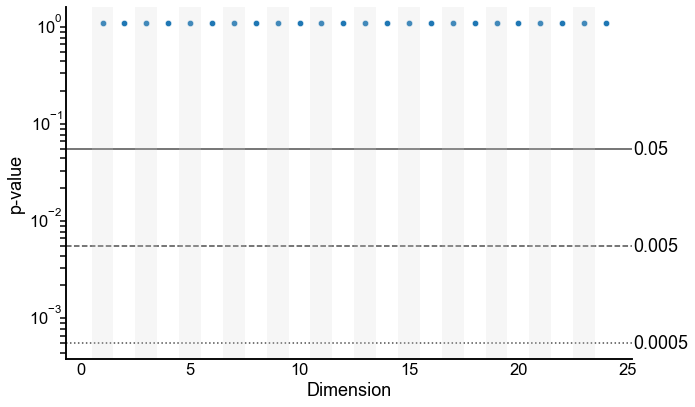

In [7]:


def plot_pvalues(results, line_locs=[0.05, 0.005, 0.0005]):
    results = results.copy()

    styles = ["-", "--", ":"]
    line_kws = dict(color="black", alpha=0.7, linewidth=1.5, zorder=-1)

    # plot p-values by embedding dimension
    _, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.scatterplot(
        data=results,
        x="n_components",
        y="pvalue",
        ax=ax,
        s=40,
    )
    ax.set_yscale("log")
    styles = ["-", "--", ":"]
    line_kws = dict(color="black", alpha=0.7, linewidth=1.5, zorder=-1)
    for loc, style in zip(line_locs, styles):
        ax.axhline(loc, linestyle=style, **line_kws)
        ax.text(ax.get_xlim()[-1] + 0.1, loc, loc, ha="left", va="center")
    ax.set(xlabel="Dimension", ylabel="p-value")
    # ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left", title="Alignment")

    xlim = ax.get_xlim()
    for x in range(1, int(xlim[1]), 2):
        ax.axvspan(x - 0.5, x + 0.5, color="lightgrey", alpha=0.2, linewidth=0)

    plt.tight_layout()


plot_pvalues(results)
stashfig(
    f"naive-pvalues-test={test}-n_bootstraps={n_bootstraps}-preprocess={preprocess}"
)

## Now do a synthetic alternative experiment

In [8]:
from sklearn.preprocessing import normalize

align_n_components = 16
n_perturb = 10
do_normalize = True
groups = ["None", "MBONs", "MBINs", "PNs", "KCs", "sensories", "LNs"]
rows = []
for group in groups:
    print(group)
    ll_adj_perturbed = ll_adj_to_embed.copy()
    if group != "None":
        group_nodes = left_nodes[left_nodes["simple_group"] == group]
        effective_n_perturb = min(n_perturb, len(group_nodes))
        perturb_index = np.random.choice(
            group_nodes.index, size=effective_n_perturb, replace=False
        )
        perturb_inds = group_nodes.loc[perturb_index, "_inds"]
        for i in perturb_inds:
            perm_inds = np.random.permutation(len(ll_adj))
            ll_adj_perturbed[i] = ll_adj_perturbed[i, perm_inds]
            perm_inds = np.random.permutation(len(ll_adj))
            ll_adj_perturbed[:, i] = ll_adj_perturbed[perm_inds, i]
    else:
        effective_n_perturb = 0
    X_ll, Y_ll, left_sing_vals, left_elbow_inds = embed(
        ll_adj_perturbed, n_components=align_n_components
    )
    X_rr, Y_rr, right_sing_vals, right_elbow_inds = embed(
        rr_adj_to_embed, n_components=align_n_components
    )
    if do_normalize:
        X_ll = normalize(X_ll)
        Y_ll = normalize(Y_ll)
        X_rr = normalize(X_rr)
        Y_rr = normalize(Y_rr)
    X_ll, Y_ll = joint_procrustes(
        (X_ll, Y_ll),
        (X_rr, Y_rr),
        method="seeded",
        seeds=(left_paired_inds, right_paired_inds_shifted),
    )

    for n_components in np.arange(1, align_n_components + 1):
        left_composite_latent = np.concatenate(
            (X_ll[:, :n_components], Y_ll[:, :n_components]), axis=1
        )
        # left_composite_latent = normalize(left_composite_latent)
        right_composite_latent = np.concatenate(
            (X_rr[:, :n_components], Y_rr[:, :n_components]), axis=1
        )
        # right_composite_latent = normalize(right_composite_latent)

        run_test(
            left_composite_latent,
            right_composite_latent,
            rows,
            info={
                "alignment": "SOP",
                "n_components": n_components,
                "perturb_group": group,
                "n_perturb": effective_n_perturb,
            },
        )

results = pd.DataFrame(rows)
results

None


/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


MBONs


/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


MBINs


/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


PNs


/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


KCs


/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


sensories


/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


LNs


/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


,pvalue,tstat,elapsed,alignment,n_components,perturb_group,n_perturb
0,0.606708,-0.000248,0.871371,SOP,1,None,0
1,1.000000,-0.000479,0.792783,SOP,2,None,0
2,1.000000,-0.000662,0.780576,SOP,3,None,0
3,1.000000,-0.000716,0.782053,SOP,4,None,0
4,1.000000,-0.000573,0.785052,SOP,5,None,0
...,...,...,...,...,...,...,...
107,0.000745,0.003501,0.849398,SOP,12,LNs,10
108,0.000777,0.003474,0.836106,SOP,13,LNs,10
109,0.000070,0.004998,0.822985,SOP,14,LNs,10
110,0.000004,0.006799,0.860330,SOP,15,LNs,10


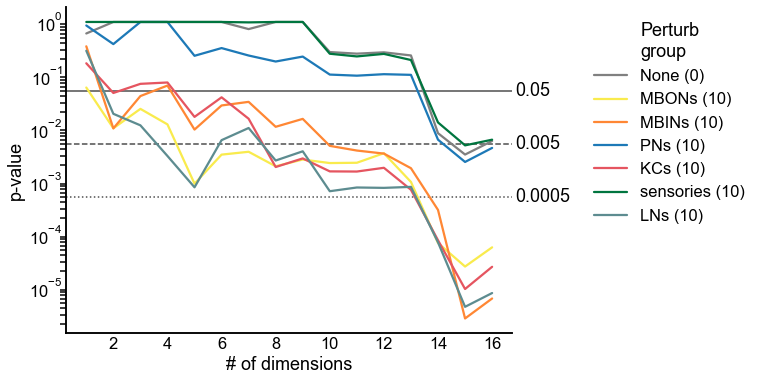

In [9]:

node_palette["None"] = "#808080"  # grey
n_perturbs = results.groupby("perturb_group")["n_perturb"].first()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(
    data=results,
    x="n_components",
    y="pvalue",
    hue="perturb_group",
    palette=node_palette,
)
ax.set_yscale("log")
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
    new_labels.append(label + f" ({n_perturbs[label]})")
ax.get_legend().remove()
ax.legend(
    handles=handles,
    labels=new_labels,
    bbox_to_anchor=(1.15, 1),
    loc="upper left",
    title="Perturb\ngroup",
)
styles = ["-", "--", ":"]
line_locs = [0.05, 0.005, 0.0005]
line_kws = dict(color="black", alpha=0.7, linewidth=1.5, zorder=-1)
for loc, style in zip(line_locs, styles):
    ax.axhline(loc, linestyle=style, **line_kws)
    ax.text(ax.get_xlim()[-1] + 0.1, loc, loc, ha="left", va="center")
ax.set(xlabel="# of dimensions", ylabel='p-value')
stashfig(
    f"perturb-p-values-n_perturb={n_perturb}-align_n_component={align_n_components}-normalize={do_normalize}"
)

## End

In [10]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:04:51.021215
Completed at 2021-05-16 11:32:24.080429
----
